In [113]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
BBOX_PATH = MODEL_PATH+'/bbox'

In [114]:
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import keras
import keras_cv
from keras.callbacks import EarlyStopping
from keras.preprocessing import image as keras_image
from tensorflow.keras.layers import Dense


Lade JSON

In [115]:


def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [116]:
JSON_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ JSON_NAME
data = json_read(DATA_PATH)

Bennene Bilder im Verzeichnis images und in der Annotationsdatei um

In [117]:
def rename_images(IMAGE_PATH):
    index=1
    img  = os.listdir(IMAGE_PATH)
    for i in img:
        new_name = f"{index:012d}"+'.jpeg'
        old_path = os.path.join(IMAGE_PATH, i)
        new_path = os.path.join(IMAGE_PATH, new_name)
        os.rename(old_path, new_path)
        index += 1

def rename_images_in_annotation():
    index=1
    for img in data['images']:
        new_name = f"{index:012d}"+'.jpeg'
        img['file_name'] = new_name 
        index += 1

rename_images(IMAGE_PATH+'/original')
rename_images_in_annotation()

with open(ANNOTATION_PATH+'/original' + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)  

In [118]:
images = []
bounding_boxes = []
labels = []
image_height = 1366
image_width = 768

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    box_and_id = []
    one_box.append(annotation['bbox'])
    bounding_boxes.append(one_box)

Resize

In [119]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)
        y = np.round(box[1]*height_ratio,2)
        x_width = np.round(box[2]*width_ratio,2)
        y_height = np.round(box[3]*height_ratio,2)
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


In [120]:
new_height = 640
new_width = 640
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(new_height) + 'x' + str(new_width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(new_height) + 'x' + str(new_width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy JSON Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


In [121]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], new_height, new_width)


with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], new_height, new_width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=new_height
    image['width']=new_width

with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Create Dataset

In [122]:
images = data['images']
annotations = data['annotations']
categories = data['categories']

dataset = []
dataset_main_labels = []

for annotation in annotations:
    image_info = next(image for image in images if image['id'] == annotation['image_id'])
    image_path = OUTPUT_PATH_IMAGES + '/'+ image_info['file_name']
    bbox = annotation['bbox']  # [x, y, width, height]
    class_id = annotation['category_id']

    xmin, ymin, width, height = bbox
    #xmax, ymax = xmin + width, ymin + height

    dataset.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
    })
    # (annotation['category_id'] == 1) or
    if (annotation['category_id'] == 11) or (annotation['category_id'] == 25):
        dataset_main_labels.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
        })

print('Annotations:',len(dataset))
print(dataset[0])
print(dataset_main_labels)

Annotations: 697
{'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [32.81, 171.74, 401.16, 142.67], 'class_id': 1}
[{'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000002.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000002.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000003.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000003.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000004.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/64

In [123]:
def get_file_list(directory):
    file_list = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        normalized_path = os.path.normpath(full_path)
        normalized_path = normalized_path.replace(os.path.sep, '/')
        if os.path.isfile(normalized_path):
            file_list.append(normalized_path)
    return file_list

In [124]:
""""
def convert_annotations_to_array(coco_data, num_classes=41):
    annotations = coco_data['annotations']
    num_annotations = len(annotations)

    # Initialize empty arrays for bounding boxes and labels
    bounding_boxes = np.zeros((num_annotations, 4), dtype=np.float32)
    labels = np.zeros((num_annotations,), dtype=np.int32)

    for i, annotation in enumerate(annotations):
        # Extract bounding box coordinates
        bbox = annotation['bbox']
        bounding_boxes[i] = np.array([bbox[0], bbox[1], bbox[2], bbox[3]], dtype=np.float32)

        # Extract class label
        labels[i] = annotation['category_id']

    return bounding_boxes, labels


bounding_boxes, labels = convert_annotations_to_array(data)

#bbox_data = np.random.random((41, bounding_boxes))

trainTargets = {
    "class_label": labels,
    "bounding_box": bounding_boxes
}
print(bounding_boxes.shape)

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}
"""

'"\ndef convert_annotations_to_array(coco_data, num_classes=41):\n    annotations = coco_data[\'annotations\']\n    num_annotations = len(annotations)\n\n    # Initialize empty arrays for bounding boxes and labels\n    bounding_boxes = np.zeros((num_annotations, 4), dtype=np.float32)\n    labels = np.zeros((num_annotations,), dtype=np.int32)\n\n    for i, annotation in enumerate(annotations):\n        # Extract bounding box coordinates\n        bbox = annotation[\'bbox\']\n        bounding_boxes[i] = np.array([bbox[0], bbox[1], bbox[2], bbox[3]], dtype=np.float32)\n\n        # Extract class label\n        labels[i] = annotation[\'category_id\']\n\n    return bounding_boxes, labels\n\n\nbounding_boxes, labels = convert_annotations_to_array(data)\n\n#bbox_data = np.random.random((41, bounding_boxes))\n\ntrainTargets = {\n    "class_label": labels,\n    "bounding_box": bounding_boxes\n}\nprint(bounding_boxes.shape)\n\ntestTargets = {\n    "class_label": testLabels,\n    "bounding_box": te

In [125]:
directory_path = OUTPUT_PATH_IMAGES
files = get_file_list(directory_path)


bbox_list=[]
class_id_list=[]
image_path_list=[]

for k in files:
    ann_bbox=[]
    ann_class_id=[]
    for i in dataset:
        d = i
        if d['image_path'] == k:
            ann_bbox.append(d['bbox'])
            #ann_bbox.append(d['class_id'])
            ann_class_id.append(d['class_id'])
    
    image = cv2.imread(d['image_path'])
    image = image / 255.0 

        
    bbox_list.append(ann_bbox)
    class_id_list.append(ann_class_id)
    image_path_list.append(image)

images_data = np.array(image_path_list)
bounding_boxes = np.array(bbox_list)
class_labels = np.array(class_id_list)

print(images_data.shape)
print(bounding_boxes.shape)
print(class_labels.shape)


(17, 640, 640, 3)
(17, 41, 4)
(17, 41)


In [126]:
#main Boxes
directory_path = OUTPUT_PATH_IMAGES
files = get_file_list(directory_path)


main_bbox_list=[]
main_class_id_list=[]
main_image_path_list=[]

for k in files:
    main_ann_bbox=[]
    main_ann_class_id=[]
    for i in dataset_main_labels:
        d = i
        if d['image_path'] == k:
            main_ann_bbox.append(d['bbox'])
            #ann_bbox.append(d['class_id'])
            main_ann_class_id.append(d['class_id'])

    
    image = cv2.imread(d['image_path'])
    image = image / 255.0 

        
    main_bbox_list.append(main_ann_bbox)
    main_class_id_list.append(main_ann_class_id)
    main_image_path_list.append(image)

main_images_data = np.array(main_image_path_list)
main_bounding_boxes = np.array(main_bbox_list)
main_class_labels = np.array(main_class_id_list)

print(main_images_data.shape)
print(main_bounding_boxes.shape)
print(main_class_labels.shape)

(17, 640, 640, 3)
(17, 2, 4)
(17, 2)


In [127]:
class_ids = []

for cat in data['categories']:
    class_name = cat['name']
    class_ids.append(class_name)
class_mapping = dict(zip(range(len(class_ids)), class_ids))
print(len(class_ids))

42


Yolo

In [128]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [129]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone",  #pretrained
    input_shape=(new_width, new_height, 3),
)
#Freeze base model
#base_model.trainable = False

In [137]:
YOLO_PATH = BBOX_PATH+'/yolov8_backbone.keras'
yolo = keras.models.load_model(YOLO_PATH)

In [138]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)

In [139]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
            classification_loss="binary_crossentropy", 
            box_loss="ciou",
            optimizer=tf.optimizers.SGD(global_clipnorm=10.0),)
yolo.summary()

Model: "yolov8_detector_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        {'P3': (None, 80, 80, 128)   5089760   ['input_12[0][0]']            
                             , 'P4': (None, 40, 40, 256                                           
                             ),                                                                   
                              'P5': (None, 20, 20, 512)                                           
                             }                                                                    
                                                                                  

                                                                                                  
 pa_fpn_p4p5_pre_0_1 (Activ  (None, 40, 40, 128)          0         ['pa_fpn_p4p5_pre_0_1_bn[0][0]
 ation)                                                             ']                            
                                                                                                  
 pa_fpn_p4p5_pre_0_2_pad (Z  (None, 42, 42, 128)          0         ['pa_fpn_p4p5_pre_0_1[0][0]'] 
 eroPadding2D)                                                                                    
                                                                                                  
 pa_fpn_p4p5_pre_0_2_conv (  (None, 40, 40, 128)          147456    ['pa_fpn_p4p5_pre_0_2_pad[0][0
 Conv2D)                                                            ]']                           
                                                                                                  
 pa_fpn_p4

In [140]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=10,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history = yolo.fit(
    images_data, 
    {"classes": class_labels,"boxes": bounding_boxes},
    epochs=40,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/40
1/1 [==============================] - 25s 25s/step - loss: 96.3851 - box_loss: 6.0781 - class_loss: 90.3070
Epoch 2/40
1/1 [==============================] - 8s 8s/step - loss: 93.8082 - box_loss: 6.0620 - class_loss: 87.7462
Epoch 3/40
1/1 [==============================] - 7s 7s/step - loss: 91.9639 - box_loss: 6.0785 - class_loss: 85.8854
Epoch 4/40
1/1 [==============================] - 7s 7s/step - loss: 90.7374 - box_loss: 6.0788 - class_loss: 84.6586
Epoch 5/40
1/1 [==============================] - 8s 8s/step - loss: 90.0383 - box_loss: 6.0488 - class_loss: 83.9895
Epoch 6/40
1/1 [==============================] - 7s 7s/step - loss: 88.7569 - box_loss: 6.0668 - class_loss: 82.6901
Epoch 7/40
1/1 [==============================] - 7s 7s/step - loss: 89.4162 - box_loss: 6.0680 - class_loss: 83.3482
Epoch 8/40
1/1 [==============================] - 8s 8s/step - loss: 87.9682 - box_loss: 6.0457 - class_loss: 81.9225
Epoch 9/40
1/1 [==============================] - 8s 8

In [ ]:
yolo.get_config() 
YOLO_PATH = BBOX_PATH+'/yolov8_backbone.keras'
#yolo.save(YOLO_PATH)

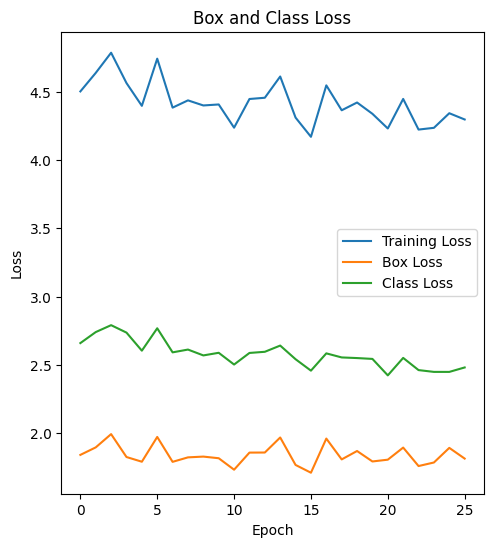

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['box_loss'], label='Box Loss')
    plt.plot(history.history['class_loss'], label='Class Loss')
    plt.title('Box and Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_metrics(history)

In [ ]:
def predict_at_image(model, image_path):
    img = keras_image.load_img(image_path, target_size=(new_height, new_width))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_classes =np.array(predictions['classes'])
    predicted_boxes =np.array(predictions['boxes'])
    predicted_confidence = np.array(predictions['confidence'])

    return predicted_classes,predicted_boxes,predicted_confidence


def plot_bounding_boxes(boxes, image_path):
    img = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()

1/1 [==============================] - 0s 102ms/step


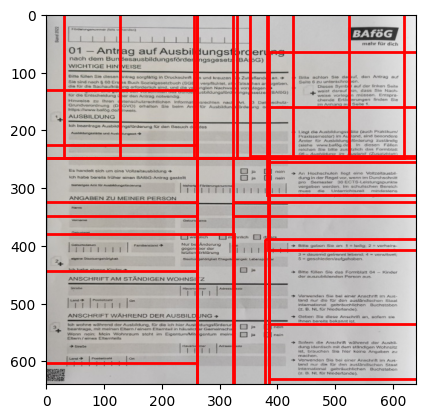

1/1 [==============================] - 0s 100ms/step


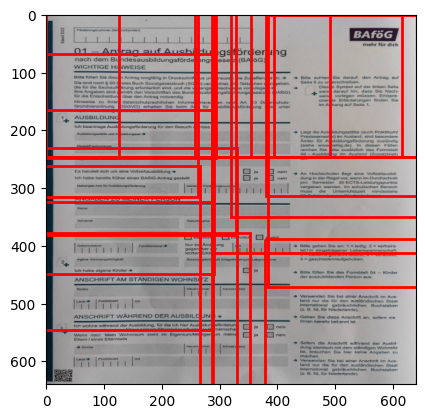

1/1 [==============================] - 0s 107ms/step


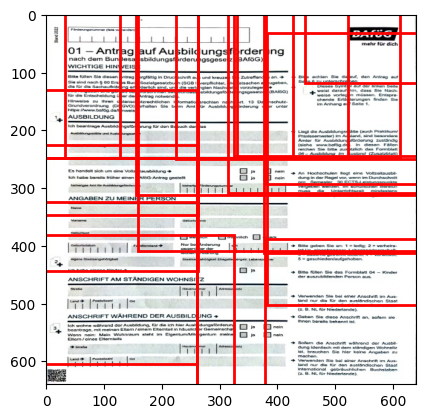

1/1 [==============================] - 0s 98ms/step


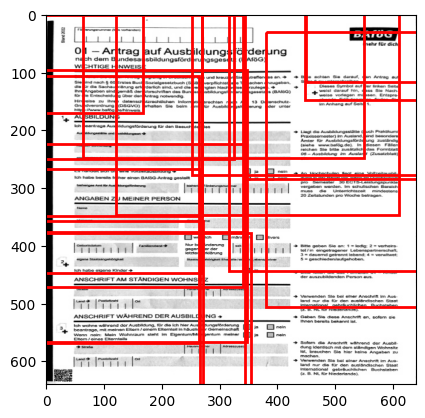

1/1 [==============================] - 0s 99ms/step


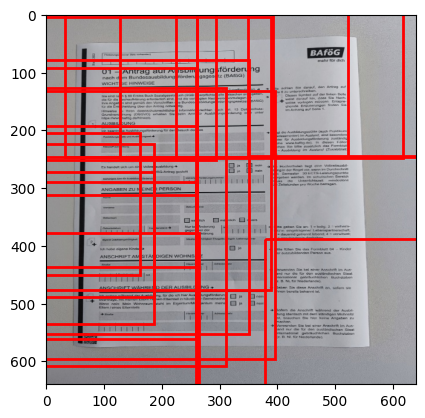

1/1 [==============================] - 0s 97ms/step


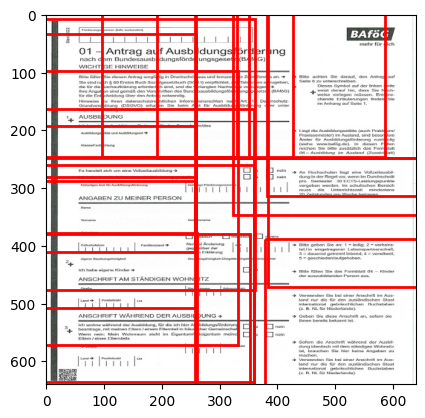

1/1 [==============================] - 0s 101ms/step


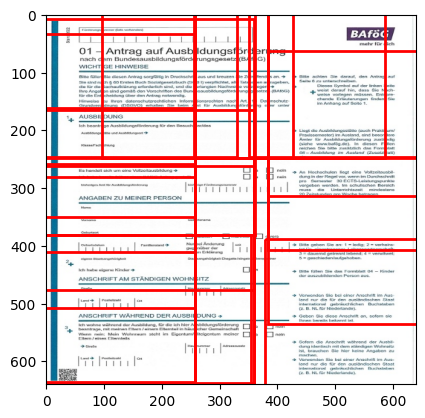

1/1 [==============================] - 0s 100ms/step


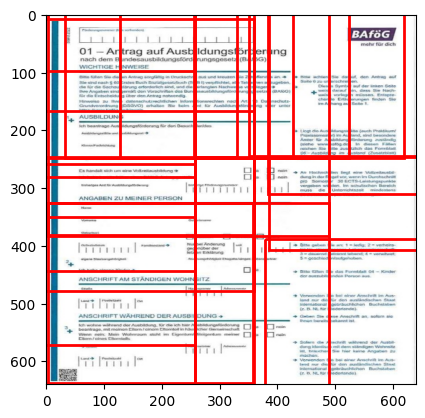

In [ ]:
for i in range(1,9):
    image_to_preict = OUTPUT_PATH_IMAGES + '/00000000000'+str(i)+'.jpeg'

    predicted_classes,predicted_boxes,predicted_confidence = predict_at_image(yolo,image_to_preict)
    predicted_boxes_array = predicted_boxes.reshape(-1, 4)
    sliced_array = predicted_boxes_array[:20]
    plot_bounding_boxes(sliced_array, image_to_preict)

    #print(predicted_classes)
    #print(predicted_boxes)
    #print(predicted_boxes)

Yolo Main Labels

In [ ]:
yolo_main_labbels = keras_cv.models.YOLOV8Detector(
    num_classes=26,
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo_main_labbels.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")
yolo_main_labbels.summary()

Model: "yolov8_detector_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        {'P3': (None, 80, 80, 128)   5089760   ['input_3[0][0]']             
                             , 'P4': (None, 40, 40, 256                                           
                             ),                                                                   
                              'P5': (None, 20, 20, 512)                                           
                             }                                                                    
                                                                                  

 eroPadding2D)                                                                                    
                                                                                                  
 pa_fpn_p4p5_pre_0_2_conv (  (None, 40, 40, 128)          147456    ['pa_fpn_p4p5_pre_0_2_pad[0][0
 Conv2D)                                                            ]']                           
                                                                                                  
 pa_fpn_p4p5_pre_0_2_bn (Ba  (None, 40, 40, 128)          512       ['pa_fpn_p4p5_pre_0_2_conv[0][
 tchNormalization)                                                  0]']                          
                                                                                                  
 pa_fpn_p4p5_pre_0_2 (Activ  (None, 40, 40, 128)          0         ['pa_fpn_p4p5_pre_0_2_bn[0][0]
 ation)                                                             ']                            
          

In [ ]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history_main_labels = yolo_main_labbels.fit(
    images_data, 
    {"classes": main_class_labels,"boxes": main_bounding_boxes},
    epochs=6,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/6
1/1 [==============================] - 32s 32s/step - loss: 571.2216 - box_loss: 4.7972 - class_loss: 566.4244
Epoch 2/6
1/1 [==============================] - 7s 7s/step - loss: 496.1934 - box_loss: 4.7295 - class_loss: 491.4639
Epoch 3/6
1/1 [==============================] - 8s 8s/step - loss: 449.0379 - box_loss: 4.6231 - class_loss: 444.4148
Epoch 4/6
1/1 [==============================] - 7s 7s/step - loss: 390.2563 - box_loss: 4.3795 - class_loss: 385.8769
Epoch 5/6
1/1 [==============================] - 7s 7s/step - loss: 351.6099 - box_loss: 4.0409 - class_loss: 347.5690
Epoch 6/6
1/1 [==============================] - 7s 7s/step - loss: 302.6866 - box_loss: 3.5917 - class_loss: 299.0948


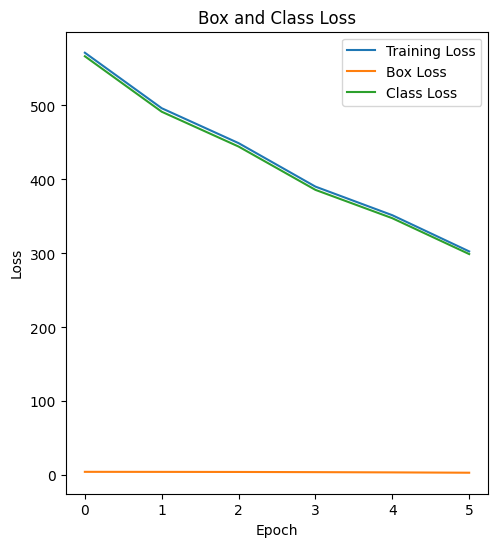

In [ ]:
plot_metrics(history_main_labels)

In [ ]:
image_path = OUTPUT_PATH_IMAGES + '/000000000001.jpeg'

main_predicted_boxes_array = main_predicted_boxes.reshape(-1, 4)
main_sliced_array = main_predicted_boxes_array[:40]
print(main_sliced_array)
plot_bounding_boxes(main_sliced_array, image_path)

NameError: name 'main_predicted_boxes' is not defined

Transfer Learning

In [ ]:
""""
base_model = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
    load_weights=False,
)
#Freeze base model
base_model.trainable = False
"""

base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(new_height, new_width, 3),
    include_top=False)  #ImageNet classifier false

base_model.trainable = False


In [ ]:
inputs = keras.Input(shape=(new_height, new_width, 3))
x = base_model(inputs, training=False)

# Global Average Pooling Layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Dense-Schichten zur Reduzierung auf 4 Neuronen
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

class_id_output = keras.layers.Dense(41, activation='softmax', name='class_id')(x)

bbox_output = keras.layers.Dense(4, name='bbox')(x)
model_xception = keras.Model(inputs, [class_id_output, bbox_output]) 

model_xception.compile(
    optimizer=keras.optimizers.Adam(),  
    loss={'class_id': 'categorical_crossentropy', 'bbox': 'mean_squared_error'},#Regression für bbox
    metrics=["sparse_categorical_accuracy"]
    #metrics={'class_id': 'accuracy'}
)
model_xception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, 20, 20, 2048)         2086148   ['input_8[0][0]']             
                                                          0                                       
                                                                                                  
 global_average_pooling2d_4  (None, 2048)                 0         ['xception[4][0]']            
  (GlobalAveragePooling2D)                                                                        
                                                                                            

In [ ]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]
print(bounding_boxes.shape)
print(class_labels.shape)
print(images_data.shape)

history_xception = model_xception.fit(
    images_data, 
    {"class_id": class_labels,"bbox": bounding_boxes},
    epochs=66,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

(17, 41, 4)
(17, 41)
(17, 640, 640, 3)
Epoch 1/66


ValueError: in user code:

    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\metrics\accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 41 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](Cast_3)' with input shapes: [?,41].
